## Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between


https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [1]:
import numpy
import scipy.io.wavfile
import os
import librosa.display
from matplotlib import cm # for color map

from scipy.fftpack import dct
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
save_path = "./test_train_data/"
user_list = os.listdir(save_path)
user_list.sort()

print("User List :")
for i, item in zip(range(len(user_list)), user_list):
    print('[{:d}] '.format(i)+item)

selUserNum = int(input("\n유저 번호를 선택하세요 : "))

file_list = os.listdir(save_path + str(user_list[selUserNum]+"/"))
file_list.sort()

print("\nFile List : ")
for i, item in zip(range(len(file_list)), file_list):
    print('[{:d}] '.format(i)+item)
    
selFileNum = int(input("\n파일 번호를 선택하세요 : "))

final_file_name = save_path + str(user_list[selUserNum]) +"/"+ str(file_list[selFileNum])

User List :
[0] juheon
[1] kimsubin

유저 번호를 선택하세요 : 1

File List : 
[0] kimsubin_0.wav
[1] kimsubin_1.wav
[2] kimsubin_2.wav
[3] kimsubin_3.wav
[4] kimsubin_4.wav
[5] kimsubin_5.wav
[6] kimsubin_6.wav

파일 번호를 선택하세요 : 6


In [3]:
sample_rate, signal = scipy.io.wavfile.read(final_file_name)  # File assumed to be in the same directory
# signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

In [4]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [5]:
frame_size = 0.025
frame_stride = 0.01


frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

In [6]:
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

In [7]:
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [8]:
low_freq_mel = 0
nfilt = 40
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

/home/subin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'shape' parameter of imshow() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'shape', they should be pass as keyword, not positionally.
  
/home/subin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing 'normal' to axis() is deprecated since 3.1; use 'auto' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


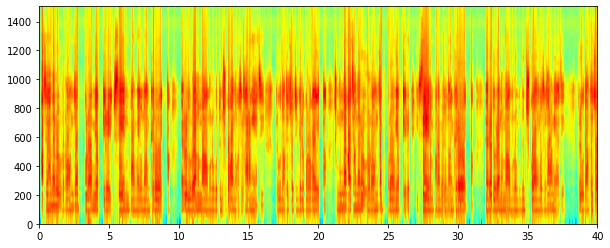

In [9]:
plt.figure(figsize=(10, 4))
plt.imshow(numpy.flipud(filter_banks.T),cmap=plt.cm.jet, aspect=0.2, extent=[0,filter_banks.shape[1],0,filter_banks.shape[0]],shape=[11, 9])
plt.axis("normal")
plt.show()

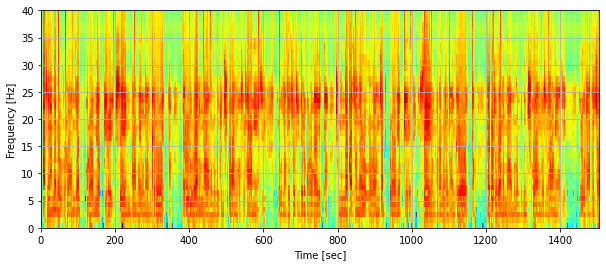

In [10]:
# plt.subplot(111)
plt.figure(figsize=(10, 4))
plt.pcolormesh(filter_banks.T, cmap= cm.jet)
plt.grid('on')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [11]:
num_ceps = 12
cep_lifter = 22
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [12]:
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*

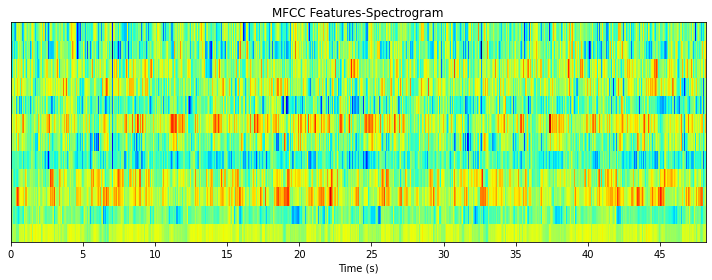

In [13]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc.T, sr=16000, hop_length=512, x_axis='s', cmap=cm.jet)
plt.title('MFCC Features-Spectrogram')
plt.tight_layout()
plt.show()

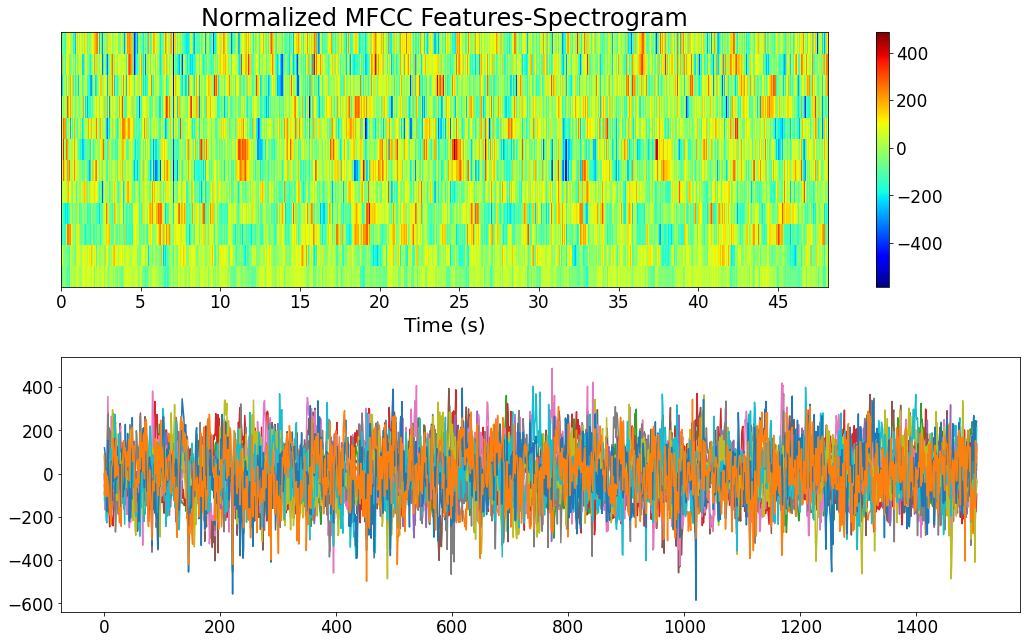

In [14]:
mfcc_normal = mfcc-(numpy.mean(mfcc, axis=0) + 1e-8)

plt.figure(figsize=(14, 9))
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=17)
plt.rc('font', size=20)


plt.subplot(2,1,1)
librosa.display.specshow(mfcc_normal.T, sr=16000, hop_length=512, x_axis='s', cmap=cm.jet)
plt.title('Normalized MFCC Features-Spectrogram')
plt.colorbar()
plt.tight_layout()


plt.subplot(2,1,2)
plt.plot(mfcc_normal)
plt.show()

